In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
#from vaderSentiment import SentimentIntensityAnalyzer

# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.------------------------ {'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.------------------------ {'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!---------------------- {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!--------- {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
VADER is not smart, handsome, nor funny.------------------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
The book was good.----------------------------------------------- {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'co

# Import and Get Buckets

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tqdm
import pandas as pd
import json
import os


# Set the Reddit Data File Path (JSON)
data_file_path = "data/florida_comments.json"

time_interval_seconds = 2 * 30 * 24 * 60 * 60 # two months
time_start = 1546300801 # 1st January 2019
time_end = 1672531201 # 1st January 2023

activity_bucket_limits = [1, 10, 100, 1000, 10000, 100000, 1000000] # Inclusive on lower bound, exclusive on upper bound - strictly integers


# Group the users into buckets based on activity during each time interval
# Create a list of dictionaries the following format: (the index in the list is the time bucket index)
# [{user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, 
#  {user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, ...]

# Initialise a list of empty dictionaries of the amount of time intervals
activity_buckets = [{} for i in range(int((time_end - time_start) / time_interval_seconds) + 1)]

# Initialise progress bar
pbar = tqdm.tqdm(total=os.path.getsize(data_file_path))

# Iterate through the data file
with open(data_file_path) as data_file:
    # Analyse each line in the data file
    for line in data_file:
        # Load the line as a JSON object
        line_json = json.loads(line)
        
        # Get the timestamp of the comment
        timestamp = int(line_json["created_utc"])
        user_id = line_json["author"]

        # Check if within start and end time
        if timestamp < time_start or timestamp > time_end:
            # Update the progress bar
            pbar.update(len(line))
            continue
        
        # Get the time interval index
        time_interval_index = int((timestamp - time_start) / time_interval_seconds)

        # Check if the user has already been added to the activity bucket
        if user_id in activity_buckets[time_interval_index]:
            # Increment the user's post count
            activity_buckets[time_interval_index][user_id] += 1
        else:
            # Add the user to the activity bucket
            activity_buckets[time_interval_index][user_id] = 1

        # Update the progress bar
        pbar.update(len(line))

# Close the progress bar
pbar.close()

# Initialise another progress bar
pbar = tqdm.tqdm(total=len(activity_buckets))

# Change the activity count into bucket indices
for time_bucket in activity_buckets:
    # Update the progress bar
    pbar.update(1)
    for user in time_bucket:
        # Iterate through the activity bucket limits
        for i in range(len(activity_bucket_limits)):
            # Using the activity bucket limits, find the bucket index
            if time_bucket[user] >= activity_bucket_limits[i] and time_bucket[user] < activity_bucket_limits[i + 1]:
                # Set the activity bucket to the bucket index
                time_bucket[user] = i
                break


# Close the progress bar
pbar.close()


100%|██████████| 25/25 [00:00<00:00, 104.27it/s]


In [3]:
# Set the CSV file path
csv_file_path = f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv'

run_CSV_creation = True

if run_CSV_creation:
    # Intialise the progress bar based on the number of items in the data file
    with open(data_file_path) as f:
        num_lines = sum(1 for line in f)

    pbar = tqdm.tqdm(total=num_lines)

    # Read the data file and add the data to the csv file
    with open(data_file_path) as f:
        with open(csv_file_path, 'w') as csv_file:

            # Clear the csv file of any existing data
            csv_file.truncate(0)

            for line in f:
                Sentiment_by_bucket = json.loads(line)
                utc_timestamp = Sentiment_by_bucket['created_utc']
                LIWC_categories = analyzer.polarity_scores(Sentiment_by_bucket['body'])
                author = Sentiment_by_bucket['author']

                # Check if post is within the time interval
                if int(utc_timestamp) < time_start or int(utc_timestamp) > time_end:
                    pbar.update(1)
                    continue

                # Determine the activity bucket index
                time_interval_index = int((int(utc_timestamp) - time_start) / time_interval_seconds)
                activity_buckets_index = activity_buckets[time_interval_index][author]

                # Write the data to the csv file
                csv_file.write(f'{utc_timestamp},"{LIWC_categories}", {activity_buckets_index}\n')

                # Update the progress bar
                pbar.update(1)
            

    # Close the progress bar
    pbar.close()


100%|██████████| 1293082/1293082 [11:16<00:00, 1911.71it/s]


In [4]:
# Load the data from the csv file into a dataframe
df = pd.read_csv(csv_file_path)

# Add headers to the dataframe
df.columns = ['utc_timestamp', 'Sentiment', 'activity_bucket_index']

df.head()

,utc_timestamp,Sentiment,activity_bucket_index
0,1546301518,"{'neg': 0.034, 'neu': 0.87, 'pos': 0.096, 'com...",1
1,1546301651,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",1
2,1546301940,"{'neg': 0.049, 'neu': 0.76, 'pos': 0.19, 'comp...",0
3,1546301963,"{'neg': 0.399, 'neu': 0.286, 'pos': 0.315, 'co...",1
4,1546302157,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0


In [5]:
import numpy as np

# Calculate time bucket intervals
time_buckets = range(int(time_start), int(time_end) + int(time_interval_seconds), int(time_interval_seconds))


# Change the utc_timestamp to the bucket number, e.g. the 0th bucket is between the 0th index and the 1st index of the time_buckets
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: np.searchsorted(time_buckets, x) - 1)


df.head()

,utc_timestamp,Sentiment,activity_bucket_index
0,0,"{'neg': 0.034, 'neu': 0.87, 'pos': 0.096, 'com...",1
1,0,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",1
2,0,"{'neg': 0.049, 'neu': 0.76, 'pos': 0.19, 'comp...",0
3,0,"{'neg': 0.399, 'neu': 0.286, 'pos': 0.315, 'co...",1
4,0,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0


In [6]:
# Create a dict of series in the form {activity_bucket_index: Average Compound Score Series For Each Time Bucket Series}
# The series is an array of the average compound score for each time bucket

# Initialise the dict
activity_bucket_dict_compound = {}
activity_bucket_dict_pos = {}
activity_bucket_dict_neu = {}
activity_bucket_dict_neg = {}

# Initialise the progress bar
pbar = tqdm.tqdm(total=len(activity_bucket_limits))

# Iterate through the activity bucket indices
for activity_bucket_index in range(len(activity_bucket_limits)):

    # Iterate through the time buckets
    for time_bucket in range(len(time_buckets) - 1):
        # Get the rows of the dataframe that match the activity bucket index and the time bucket
        df_activity_bucket_time_bucket = df[(df['activity_bucket_index'] == activity_bucket_index) & (df['utc_timestamp'] == time_bucket)]

        # If there are no rows, add a 0 to the dict
        if len(df_activity_bucket_time_bucket) == 0:
            if activity_bucket_index in activity_bucket_dict_compound:
                activity_bucket_dict_compound[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_compound[activity_bucket_index] = [0]

            if activity_bucket_index in activity_bucket_dict_neg:
                activity_bucket_dict_neg[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_neg[activity_bucket_index] = [0]

            if activity_bucket_index in activity_bucket_dict_neu:
                activity_bucket_dict_neu[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_neu[activity_bucket_index] = [0]

            if activity_bucket_index in activity_bucket_dict_pos:
                activity_bucket_dict_pos[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_pos[activity_bucket_index] = [0]
            continue

        sentiment_series_compound = []
        sentiment_series_pos = []
        sentiment_series_neu = []
        sentiment_series_neg = []

        # Iterate through the rows
        for index, row in df_activity_bucket_time_bucket.iterrows():
            # Get the sentiment series
            sentiment_series_compound.append(eval(row['Sentiment'])['compound'])
            sentiment_series_pos.append(eval(row['Sentiment'])['pos'])
            sentiment_series_neu.append(eval(row['Sentiment'])['neu'])
            sentiment_series_neg.append(eval(row['Sentiment'])['neg'])
        
        # Calculate the average compound score
        average_compound_score = np.mean(sentiment_series_compound)
        average_pos_score = np.mean(sentiment_series_pos)
        average_neu_score = np.mean(sentiment_series_neu)
        average_neg_score = np.mean(sentiment_series_neg)

        # Add the average compound score to the dict
        if activity_bucket_index in activity_bucket_dict_compound:
            activity_bucket_dict_compound[activity_bucket_index].append(average_compound_score)
        else:
            activity_bucket_dict_compound[activity_bucket_index] = [average_compound_score]

        if activity_bucket_index in activity_bucket_dict_neg:
            activity_bucket_dict_neg[activity_bucket_index].append(average_neg_score)
        else:
            activity_bucket_dict_neg[activity_bucket_index] = [average_neg_score]

        if activity_bucket_index in activity_bucket_dict_neu:
            activity_bucket_dict_neu[activity_bucket_index].append(average_neu_score)
        else:
            activity_bucket_dict_neu[activity_bucket_index] = [average_neu_score]

        if activity_bucket_index in activity_bucket_dict_pos:
            activity_bucket_dict_pos[activity_bucket_index].append(average_pos_score)
        else:
            activity_bucket_dict_pos[activity_bucket_index] = [average_pos_score]


    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

print(activity_bucket_dict_compound)

# Typical Run Time: 3 minutes 40 seconds

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [06:51<00:00, 58.74s/it] 

{0: [0.10034112519809826, 0.13457206436648303, 0.13182995183624324, 0.10588480492813142, 0.11258594723134413, 0.10125152976639036, 0.13011132626402336, 0.06540236601541495, 0.07903636864512899, 0.06411429238891746, 0.10469170835228134, 0.10917934927424446, 0.1379956497438286, 0.11418550162324807, 0.09782874817081282, 0.07582420822022193, 0.08028204298449139, 0.11912577962577961, 0.10062176414189837, 0.07691397718202732, 0.08438999044159816, 0.08527305260182995, 0.07262795539819268, 0.08681513423285575, 0.11568701153703015], 1: [0.0712310701256587, 0.09133807339449541, 0.08229576179091501, 0.06491077902988732, 0.0818753144654088, 0.07382514150943396, 0.11478633949826038, 0.03280024158993527, 0.05354271491479992, 0.036078981898930086, 0.0778679201223931, 0.06835072028281042, 0.10885495294700347, 0.10106585040495474, 0.07716636401732085, 0.051635068815646515, 0.05805244964262508, 0.0800598091691878, 0.06226643659711076, 0.04617797778935974, 0.04515693017296605, 0.07097970316437972, 0.0616

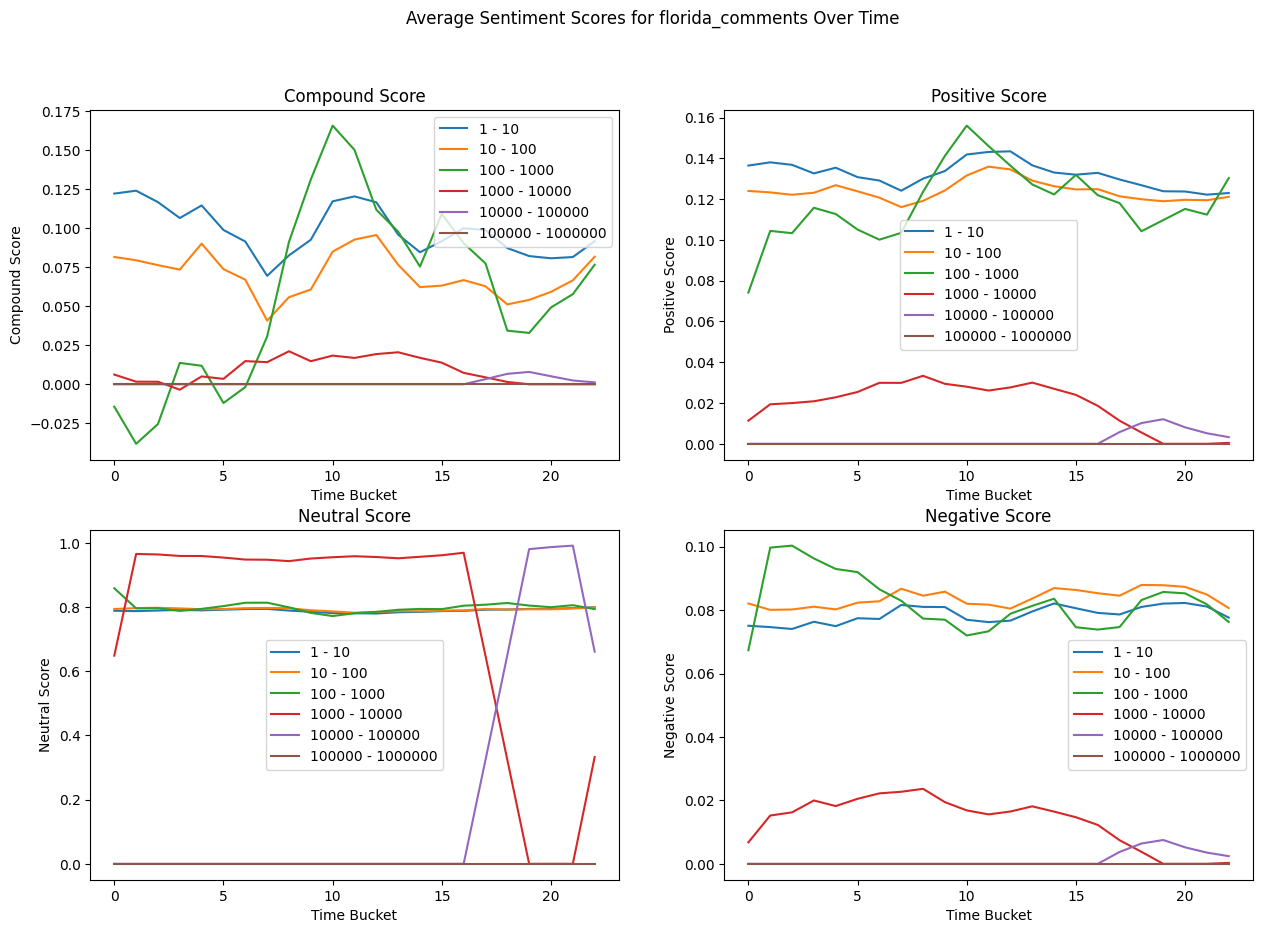

In [7]:
# Graph all four sentiment scores over time for each activity bucket index
import matplotlib.pyplot as plt

# Initialise the plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Iterate through the activity bucket indices
for activity_bucket_index in range(len(activity_bucket_limits) - 1):

    # Calculate moving average for all four sentiment scores by averaging previous, current and next values
    activity_bucket_dict_compound[activity_bucket_index] = np.convolve(activity_bucket_dict_compound[activity_bucket_index], np.ones(3), 'same') / 3
    activity_bucket_dict_pos[activity_bucket_index] = np.convolve(activity_bucket_dict_pos[activity_bucket_index], np.ones(3), 'same') / 3
    activity_bucket_dict_neu[activity_bucket_index] = np.convolve(activity_bucket_dict_neu[activity_bucket_index], np.ones(3), 'same') / 3
    activity_bucket_dict_neg[activity_bucket_index] = np.convolve(activity_bucket_dict_neg[activity_bucket_index], np.ones(3), 'same') / 3

    # Remove first and last values of all four sentiment scores
    activity_bucket_dict_compound[activity_bucket_index] = activity_bucket_dict_compound[activity_bucket_index][1:-1]
    activity_bucket_dict_pos[activity_bucket_index] = activity_bucket_dict_pos[activity_bucket_index][1:-1]
    activity_bucket_dict_neu[activity_bucket_index] = activity_bucket_dict_neu[activity_bucket_index][1:-1]
    activity_bucket_dict_neg[activity_bucket_index] = activity_bucket_dict_neg[activity_bucket_index][1:-1]

    # Plot the compound score
    axs[0, 0].plot(activity_bucket_dict_compound[activity_bucket_index], label=f'{activity_bucket_limits[activity_bucket_index]} - {activity_bucket_limits[activity_bucket_index + 1]}')
    axs[0, 0].set_title('Compound Score')
    axs[0, 0].set_xlabel('Time Bucket')
    axs[0, 0].set_ylabel('Compound Score')
    axs[0, 0].legend()

    # Plot the positive score
    axs[0, 1].plot(activity_bucket_dict_pos[activity_bucket_index], label=f'{activity_bucket_limits[activity_bucket_index]} - {activity_bucket_limits[activity_bucket_index + 1]}')
    axs[0, 1].set_title('Positive Score')
    axs[0, 1].set_xlabel('Time Bucket')
    axs[0, 1].set_ylabel('Positive Score')
    axs[0, 1].legend()

    # Plot the neutral score
    axs[1, 0].plot(activity_bucket_dict_neu[activity_bucket_index], label=f'{activity_bucket_limits[activity_bucket_index]} - {activity_bucket_limits[activity_bucket_index + 1]}')
    axs[1, 0].set_title('Neutral Score')
    axs[1, 0].set_xlabel('Time Bucket')
    axs[1, 0].set_ylabel('Neutral Score')
    axs[1, 0].legend()

    # Plot the negative score
    axs[1, 1].plot(activity_bucket_dict_neg[activity_bucket_index], label=f'{activity_bucket_limits[activity_bucket_index]} - {activity_bucket_limits[activity_bucket_index + 1]}')
    axs[1, 1].set_title('Negative Score')
    axs[1, 1].set_xlabel('Time Bucket')
    axs[1, 1].set_ylabel('Negative Score')
    axs[1, 1].legend()

# Give whole plot a title
fig.suptitle(f'Average Sentiment Scores for {os.path.basename(data_file_path[:-5])} Over Time')

# Show the plot
plt.show()

# Save the graph
fig.savefig(f'figures/sentiment_analysis/{os.path.basename(data_file_path[:-5])}_average_all4_score_over_time.png')

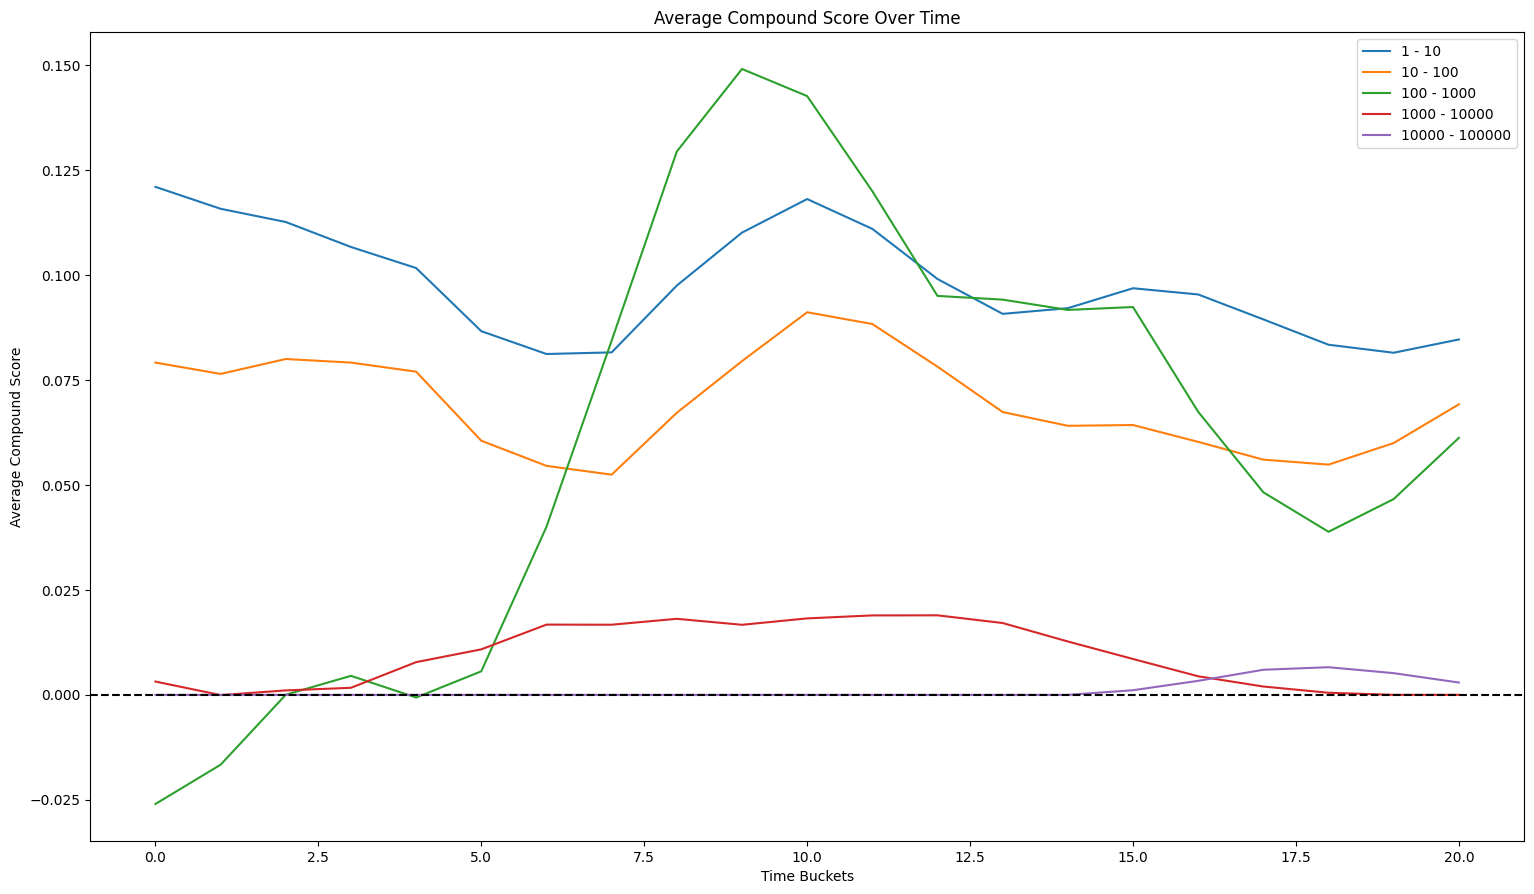

In [8]:
# Graph the data
import matplotlib.pyplot as plt

# Initialise the graph
fig, ax = plt.subplots()

# Set figure size in proportion
fig.set_size_inches(18.5, 10.5)

# Iterate through the activity bucket indices
for activity_bucket_index in range(len(activity_bucket_limits) - 2):

    # Calculate moving average by taking the average of the previous, current and next value
    activity_bucket_dict_compound[activity_bucket_index] = [(activity_bucket_dict_compound[activity_bucket_index][i - 1] + activity_bucket_dict_compound[activity_bucket_index][i] + activity_bucket_dict_compound[activity_bucket_index][i + 1]) / 3 for i in range(1, len(activity_bucket_dict_compound[activity_bucket_index]) - 1)]

    # Plot the data
    ax.plot(activity_bucket_dict_compound[activity_bucket_index], label=f'{activity_bucket_limits[activity_bucket_index]} - {activity_bucket_limits[activity_bucket_index + 1]}')

# Add a zero line
ax.axhline(y=0, color='black', linestyle='--')

# Set the x axis label
ax.set_xlabel('Time Buckets')

# Set the y axis label
ax.set_ylabel('Average Compound Score')

# Set the title
ax.set_title('Average Compound Score Over Time')

# Set the legend
ax.legend()

# Show the graph
plt.show()

# Save the graph
fig.savefig(f'figures/sentiment_analysis/{os.path.basename(data_file_path[:-5])}_average_compound_score_over_time.png')

# Spearman Testing

In [11]:
# Print the positive and negative dictionaries
print(activity_bucket_dict_pos)
print(activity_bucket_dict_neg)

VADER_activity_bucket_dict_pos = activity_bucket_dict_pos
VADER_activity_bucket_dict_neg = activity_bucket_dict_neg

{0: array([0.13646474, 0.13805284, 0.13681259, 0.13262334, 0.13541542,
       0.13079873, 0.12911764, 0.12413735, 0.13005814, 0.13377657,
       0.14189497, 0.14315522, 0.14344679, 0.13658175, 0.13304969,
       0.1319969 , 0.13288983, 0.12964399, 0.12682712, 0.12386857,
       0.12374689, 0.12220639, 0.1230043 ]), 1: array([0.12402885, 0.12330507, 0.12215474, 0.12313835, 0.12683334,
       0.12383768, 0.12071983, 0.11609609, 0.11916484, 0.1242621 ,
       0.13160801, 0.13595354, 0.13457762, 0.1290807 , 0.1263414 ,
       0.1247776 , 0.12490211, 0.12139552, 0.11996349, 0.11897619,
       0.11967305, 0.11947969, 0.12110743]), 2: array([0.07418022, 0.10442812, 0.10331219, 0.1157684 , 0.11270198,
       0.10508464, 0.10012322, 0.10347881, 0.1236079 , 0.14121382,
       0.15605397, 0.14603015, 0.13640474, 0.12721821, 0.12229858,
       0.13189998, 0.12194635, 0.11805938, 0.10425093, 0.10972285,
       0.11521024, 0.11239596, 0.13032455]), 3: array([0.01134399, 0.0193876 , 0.01997952, 0.020

## Getting the LIWC Data

In [10]:
# Set the Reddit Data File Path (JSON)
data_file_path = "data/texas_comments.json"

time_interval_seconds = 2 * 30 * 24 * 60 * 60 # two months
time_start = 1546300801 # 1st January 2019
time_end = 1672531201 # 1st January 2023

activity_bucket_limits = [1, 10, 100, 1000, 10000, 100000, 1000000] # Inclusive on lower bound, exclusive on upper bound - strictly integers

In [ ]:
import liwc
parse, category_names = liwc.load_token_parser('dictionaries/LIWC07-EN.dic')

In [ ]:
import re
from collections import Counter

def tokenize(text):
    # you may want to use a smarter tokenizer
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

def count_categories(text):
    # Returns a Counter object containing tallies of all LIWC categories
    text = text.lower()

    # Remove all words in text that are less than 3 characters long
    text = re.sub(r'\b\w{1,3}\b', '', text)

    # Remove "[removed]" and "[deleted]" from the body text
    text = re.sub(r'\[removed\]|\[deleted\]', '', text)
    
    tokens = tokenize(text)
    counter = Counter(category for token in tokens for category in parse(token))

    # If a category doesn't exist in the text, we need to add it and set the count to 0
    for category in category_names:
        if category not in counter:
            counter[category] = 0



    return counter

gettysburg = "hello world, this [removed]"

print(count_categories(gettysburg))

In [ ]:
import tqdm
import pandas as pd
import json
import os


# Group the users into buckets based on activity during each time interval
# Create a list of dictionaries the following format: (the index in the list is the time bucket index)
# [{user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, 
#  {user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, ...]

# Initialise a list of empty dictionaries of the amount of time intervals
activity_buckets = [{} for i in range(int((time_end - time_start) / time_interval_seconds) + 1)]

# Initialise progress bar
pbar = tqdm.tqdm(total=os.path.getsize(data_file_path))

# Iterate through the data file
with open(data_file_path) as data_file:
    # Analyse each line in the data file
    for line in data_file:
        # Load the line as a JSON object
        line_json = json.loads(line)
        
        # Get the timestamp of the comment
        timestamp = int(line_json["created_utc"])
        user_id = line_json["author"]

        # Check if within start and end time
        if timestamp < time_start or timestamp > time_end:
            # Update the progress bar
            pbar.update(len(line))
            continue
        
        # Get the time interval index
        time_interval_index = int((timestamp - time_start) / time_interval_seconds)

        # Check if the user has already been added to the activity bucket
        if user_id in activity_buckets[time_interval_index]:
            # Increment the user's post count
            activity_buckets[time_interval_index][user_id] += 1
        else:
            # Add the user to the activity bucket
            activity_buckets[time_interval_index][user_id] = 1

        # Update the progress bar
        pbar.update(len(line))

# Close the progress bar
pbar.close()

# Initialise another progress bar
pbar = tqdm.tqdm(total=len(activity_buckets))

# Change the activity count into bucket indices
for time_bucket in activity_buckets:
    # Update the progress bar
    pbar.update(1)
    for user in time_bucket:
        # Iterate through the activity bucket limits
        for i in range(len(activity_bucket_limits)):
            # Using the activity bucket limits, find the bucket index
            if time_bucket[user] >= activity_bucket_limits[i] and time_bucket[user] < activity_bucket_limits[i + 1]:
                # Set the activity bucket to the bucket index
                time_bucket[user] = i
                break


# Close the progress bar
pbar.close()

activity_buckets

In [ ]:
run_CSV_creation = True

if run_CSV_creation:
    # Intialise the progress bar based on the number of items in the data file
    with open(data_file_path) as f:
        num_lines = sum(1 for line in f)

    pbar = tqdm.tqdm(total=num_lines)

    # Read the data file and add the data to the csv file
    with open(data_file_path) as f:
        with open(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv', 'w') as csv_file:

            # Clear the csv file of any existing data
            csv_file.truncate(0)

            for line in f:
                LIWC_by_bucket = json.loads(line)
                utc_timestamp = LIWC_by_bucket['created_utc']
                body_text = LIWC_by_bucket['body']
                LIWC_categories = count_categories(body_text)
                author = LIWC_by_bucket['author']

                # Check if post is within the time interval
                if int(utc_timestamp) < time_start or int(utc_timestamp) > time_end:
                    pbar.update(1)
                    continue

                # Determine the activity bucket index
                time_interval_index = int((int(utc_timestamp) - time_start) / time_interval_seconds)
                activity_buckets_index = activity_buckets[time_interval_index][author]

                # Cleanse the body_text of any newlines, commas, and quotation marks, and replace them with spaces
                body_text = body_text.replace('\n', ' ').replace(',', ' ').replace('"', ' ')


                # Write the data to the csv file
                csv_file.write(f'{utc_timestamp},"{LIWC_categories}", {activity_buckets_index}, "{body_text}"\n')

                # Update the progress bar
                pbar.update(1)
            

    # Close the progress bar
    pbar.close()


In [ ]:
# Load the data from the csv file into a dataframe
df = pd.read_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv', lineterminator='\n')

# Add headers to the dataframe
df.columns = ['utc_timestamp', 'LIWC_categories', 'activity_bucket_index', 'body_text']

df.head()

In [ ]:
import numpy as np

# Calculate time bucket intervals
time_buckets = range(int(time_start), int(time_end) + int(time_interval_seconds), int(time_interval_seconds))

# Print maximum utc_timestamp
# print(df['utc_timestamp'].max())
# print("------------------")
# print(*time_buckets, sep='\n')


# Change the utc_timestamp to the bucket number, e.g. the 0th bucket is between the 0th index and the 1st index of the time_buckets
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: np.searchsorted(time_buckets, x) - 1)


df.head()

In [ ]:
# Graph the number of comments per time bucket
import matplotlib.pyplot as plt

# Delete all rows with a utc_timestamp of -1
df = df[df['utc_timestamp'] != -1]

df['utc_timestamp'].value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
plt.show()

In [ ]:
# The LIWC categories stored in a list
data = [
    'funct', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
    'ipron', 'article', 'verb', 'auxverb', 'past', 'present', 'future',
    'adverb', 'preps', 'conj', 'negate', 'quant', 'number', 'swear',
    'social', 'family', 'friend', 'humans', 'affect', 'posemo',
    'negemo', 'anx', 'anger', 'sad', 'cogmech', 'insight', 'cause',
    'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl', 'percept',
    'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest',
    'relativ', 'motion', 'space', 'time', 'work', 'achieve', 'leisure',
    'home', 'money', 'relig', 'death', 'assent', 'nonfl', 'filler'
]

# Construct a dictionary with the value in the form of a nested list, and the key as the LIWC category
# where the outer index is the activity_bucket_index, and the inner index is the time_bucket_index
# {LIWC_category: [[time_bucket_0, time_bucket_1, ...], [time_bucket_0, time_bucket_1, ...], ...]}

# Initialise the dictionary
LIWC_category_dict = {}

# Initialise the dictionary with empty nested lists
LIWC_category_dict = {category: [[0 for _ in time_buckets] for _ in activity_bucket_limits] for category in data}

print(LIWC_category_dict)

# Start a progress bar
pbar = tqdm.tqdm(total=len(df))

# Iterate through each entry in df and aggregate the LIWC categories for each time_bucket
for index, row in df.iterrows():
    # Get the time_bucket and LIWC_categories
    time_bucket = row['utc_timestamp']
    LIWC_categories = row['LIWC_categories']
    activity_bucket_index = row['activity_bucket_index']

    # Convert the LIWC_categories string to a dictionary
    LIWC_categories = eval(LIWC_categories)

    # A percentage of all LIWC words must be the selected category
    # Check that LIWC_categories[selected_category] is not zero to avoid division by zero
    if LIWC_categories[category] != 0:
        if not LIWC_categories[category] / sum(LIWC_categories.values()) > 0.05:
            # Update the progress bar
            pbar.update(1)
            continue
            

    # For each row, go through the LIWC categories and add the time_bucket to the correct list
    for category in LIWC_categories:
        LIWC_category_dict[category][activity_bucket_index][time_bucket] += (LIWC_categories[category])

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

LIWC_category_dict

In [ ]:
# {LIWC_category: [[time_bucket_0, time_bucket_1, ...], [time_bucket_0, time_bucket_1, ...], ...]}
LIWC_activity_bucket_dict_pos = LIWC_category_dict["posemo"]
LIWC_activity_bucket_dict_neg = LIWC_category_dict["negemo"]

# Print LIWC_activity_bucket_dict_pos and LIWC_activity_bucket_dict_neg
print("LIWC_activity_bucket_dicts")
print(LIWC_activity_bucket_dict_pos)
print(LIWC_activity_bucket_dict_neg)

# Print activity_bucket_dict_pos and activity_bucket_dict_neg
# Dict of series in the form {activity_bucket_index: Average Score Series For Each Time Bucket Series}
print("activity_bucket_dicts")
print(VADER_activity_bucket_dict_pos)
print(VADER_activity_bucket_dict_neg)